# Lab 2 - Fitting Outliers, & Markov Chain Monte Carlo

We are going to work through section 3 of arxiv:1008.4686.

We'll start by importing the data in Table 1.  I grabbed the LaTeX for that table and plugged it into the *get_data()* function below, and then parse it.  You don't need to read or understand this function if you don't want to!

In [168]:
function get_data()
    # This is the copy-n-pasted LaTeX of Table 1 in 1008.4686, giving the data points we're working with.
    # \tablehead{ID &$x$ & $y$ & $\sigma_y$ & $\sigma_x$ &  \multicolumn{2}{c}{$\rho_{xy}$}}
    latex = """
1 & 201 & 592 & 61 & 9 & -0 & 84\\
2 & 244 & 401 & 25 & 4 & 0 & 31\\
3 & 47 & 583 & 38 & 11 & 0 & 64\\
4 & 287 & 402 & 15 & 7 & -0 & 27\\
5 & 203 & 495 & 21 & 5 & -0 & 33\\
6 & 58 & 173 & 15 & 9 & 0 & 67\\
8 & 202 & 504 & 14 & 4 & -0 & 05\\
9 & 198 & 510 & 30 & 11 & -0 & 84\\
10 & 158 & 416 & 16 & 7 & -0 & 69\\
11 & 165 & 393 & 14 & 5 & 0 & 30\\
12 & 201 & 442 & 25 & 5 & -0 & 46\\
13 & 157 & 317 & 52 & 5 & -0 & 03\\
14 & 131 & 311 & 16 & 6 & 0 & 50\\
15 & 166 & 400 & 34 & 6 & 0 & 73\\
16 & 160 & 337 & 31 & 5 & -0 & 52\\
17 & 186 & 423 & 42 & 9 & 0 & 90\\
18 & 125 & 334 & 26 & 8 & 0 & 40\\
19 & 218 & 533 & 16 & 6 & -0 & 78\\
20 & 146 & 344 & 22 & 5 & -0 & 56\\
"""
    # first split into lines
    lines = split(latex, '\n')
    # drop empty lines
    lines = filter(x->(length(x)>0), lines)
    # create arrays for our results
    x = zeros(length(lines))
    y = zeros(length(lines))
    yerr = zeros(length(lines))
    xerr = zeros(length(lines))
    for (i,line) in enumerate(lines)
        # Split into words separated by "&", and parse as floating-point values.
        words = split(line, "&")
        x[i] = parse(Float64, words[2])
        y[i] = parse(Float64, words[3])
        yerr[i] = parse(Float64, words[4])
        xerr[i] = parse(Float64, words[5])
    end
    return x,y,xerr,yerr
end;

Now we'll call this function once to get our dataset.

In [2]:
x,y,xerr,yerr = get_data();

Before we plot the data, let's implement the linear algebra solution from last week:

In [171]:
function weighted_least_squares(x, y, yerr)
    n = length(x)
    A = zeros(eltype(x), n, 2)
    A[:,1] .= 1.
    A[:,2] = x
    A .*= (1.0 ./ yerr)
    B = A \ (y ./ yerr)
    (b,m) = B
    return (b,m)
end;

YOUR TURN!  Make a plot of the data set (do show the y error bars; for today we're going to ignore the x error bars), and the best-fit line.

In [174]:
using Plots
b,m = weighted_least_squares(x, y, yerr);

### ADD PLOTTING CODE HERE!  Plot the data and the best-fit (least-squares) line


This doesn't look very good!  This data set, unlike the data we were working with last week, has some outliers.

By eye, you can probably see that the point in the top-left, and the two rightmost data points, could be outliers.

Before we start working on modeling the outliers, we're going to take a side trip to check out Julia's optimizer.  We'll start by writing down the data log-likelihood as we did last week:

YOUR TURN -- fill in the log-likelihood!

In [177]:
function line_log_likelihood(x, y, sigma, b, m)
    return -0.5 * sum(#@. ##### ADD CODE HERE.... chi-squared expression
        )
end;

And we're going to make a "convenience" version of the function that takes a single array parameter, [b, m], and calls the *line_log_likelihood* function using our data set (with "global variables" x, y, yerr).

In [178]:
function line_lnl(bm)
    b,m = bm
    line_log_likelihood(x, y, yerr, b, m)
end;

We previously computed best-fit *b* and *m* parameters; what do you get if you call

In [ ]:
line_lnl([b,m])

You should get a value around -144

Now we're going to use Julia's *optimize* function to find these *b* and *m* as the values that optimize our log-likelihood function.

In [182]:
using Optim

In [11]:
b,m

(214.07708400199547, 1.0652097733016654)

One small annoyance: *optimize* actually wants to *minimize* a function, so we need to wrap our function with a function that returns the negative.

We have to give the *optimize* function an initial guess, and it will find a *local* optimum.  Our log-likelihood space is simple, so the initial guess doesn't have to be very good in this case.

In [ ]:
func_to_minimize = x -> -line_lnl(x)
initial_guess = [0., 0.]
r = optimize(func_to_minimize, initial_guess, method=BFGS(), show_trace=true)

You can get out the parameter values that optimize the function via the *r.minimizer* element.

In [13]:
r.minimizer

2-element Array{Float64,1}:
 214.07708400586142  
   1.0652097732776988

Okay, end of digression, let's work on outliers!

To start, we'll write down the log-likelihood for the data *y* in the foreground-background model.

In [184]:
function fgbg_line_log_likelihood(x, y, sigma, b, m, pbad, Y, V)
    # If the "pbad" parameter goes outside the range 0 to 1, the prior is zero, so bail out.
    if (pbad < 0) || (pbad > 1)
        return -Inf
    end

    # ADD CODE HERE -- compute the "foreground" likelihood -- evaluate the Gaussian y ~ N(b+m*x, sigma^2)
    # Note -- don't work in log space here, and do include the 1/(sqrt(2*pi)*sigma) term.
    p_fg = #@. 
    # ADD CODE HERE -- compute the "background" likelihood -- evaluate the Gaussian y ~ N(Y, V + sigma^2)
    bg_variance = @. V + sigma^2
    p_bg = @. ...
    # Here, we weight the foreground probability by 1-pbad and the background by pbad,
    # and then take the log.
    lnl = sum(log.(
            (1. .- pbad).*p_fg .+
            pbad.*p_bg))
    # If you want to print out the inputs and outputs, you can do:
    # using Printf
    #@printf("b,m = %.3f, %.3f, pbad=%.4f, Y=%.3f, V=%.3f  --> %.3f\n", b, m, pbad, Y, V, lnl)
    return lnl
end;

As before, we'll define a "convenience" version:

In [185]:
function fgbg_line_lnl(params)
    return fgbg_line_log_likelihood(x, y, yerr, params...)
end;

To test, make sure your function returns these values:

In [186]:
fgbg_line_lnl([b, m, 0., 0., 1.])

-221.96394057665086

In [187]:
using Statistics
fgbg_line_lnl([b, m, 0.1, mean(y), var(y)])

-125.90876697361364

Above, note that even when we set *pbad = 0*, we get a different log-likelihood than the -144 value we got before -- can you think why that is?

Now we can call the optimizer on our foreground-background model!

In [ ]:
initial = [b, m, 0.1, mean(y), var(y)]
r = optimize(x-> -fgbg_line_lnl(x), initial, method=BFGS(), show_trace=true)

Here are the params that optimize the function:

In [19]:
r.minimizer

5-element Array{Float64,1}:
   255.61974100029147  
     0.5286310788113302
     0.2691345127475564
   436.2177231238664   
 10659.25912630814     

Let's pull out the b,m terms and plot them:

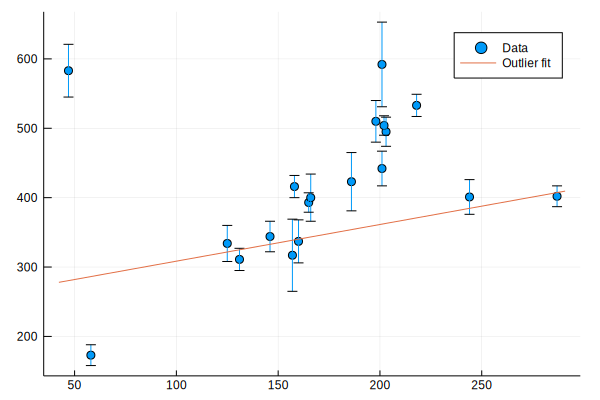

In [21]:
bx,mx = r.minimizer[1:2]
plot(x, y, yerr=yerr, seriestype=:scatter, label="Data")
plot!(x->bx+mx*x, label="Outlier fit")

Does this make you happy?

Remember how I said the optimizer finds a *local* minimum?  Can you try initializing it in a part of parameter space that looks about right?

In [ ]:
#### ADD CODE HERE --- eyeball values for b,m to yield a nicer fit!
initial2 = # [BBBB, MMMM, 0.1, mean(y), var(y)]
r2 = optimize(x-> -fgbg_line_lnl(x), initial2, method=BFGS());
p2 = r2.minimizer
b2,m2 = p2[1:2]

And just for kicks, here's another initialization:

In [ ]:
initial3 = [650, -1., 0.9, mean(y), var(y)]
r3 = optimize(x-> -fgbg_line_lnl(x), initial3, method=BFGS());
p3 = r3.minimizer
b3,m3 = p3[1:2]

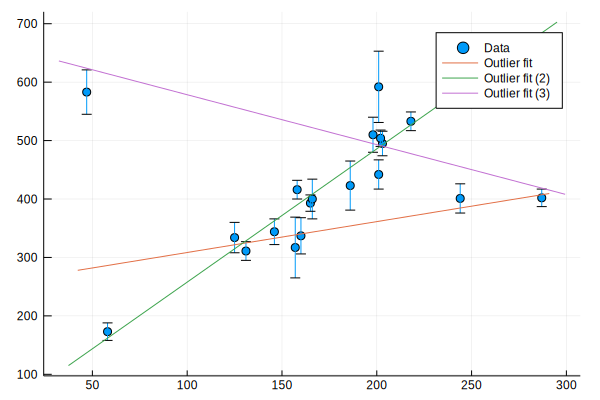

In [24]:
plot(x, y, yerr=yerr, seriestype=:scatter, label="Data")
plot!(x->bx+mx*x, label="Outlier fit (1)")
plot!(x->b2+m2*x, label="Outlier fit (2)")
plot!(x->b3+m3*x, label="Outlier fit (3)")

Let's look at what the likelihood looks like for a given *x* value (100

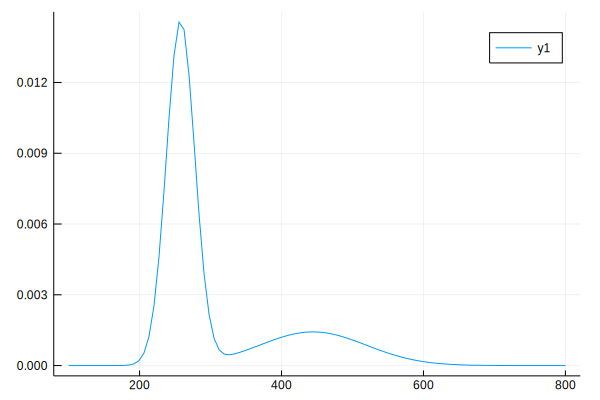

In [31]:
yy = range(100, stop=800, length=100)
plot(yy, y->exp(fgbg_line_log_likelihood(100., y, 20., p2...)))